In [1]:
from lma.jupyter.setupJupyter import setupJupyter; setupJupyter(plotStyle='paper', plotDpi=150) #plotTheme='light',
import h5py
from pathlib import Path
import numpy as np
import matplotlib as mpl

In [184]:
def getdata(hdfpth, names, cols, kind=None, oparam_cols=None, oparam_coeffs=None):
    if kind is not None: hdfpth = hdfpth % kind

    with h5py.File(hdfpth) as f:
        data = []
        for name in names:
            subdata = [f[name][col] for col in cols]
            if oparam_cols is not None and oparam_coeffs is not None:
                subdata.append(np.sum([coeff*f[name][col] for col,coeff in zip(oparam_cols, oparam_coeffs)], axis=0))
            data.append(subdata)
    
        return data
        
def plotts(data, ref_data=None, bins=None, binrange=None, labelx=True, labely=True, labelmeans=False, truncate=None,
           tickperiod=2, ylim=None, yticks=None,
           twinx=False, fig=None, axarr=None, axlab=None, **fig_kw):
    if fig is None and axarr is None:
        fig,axarr,axlab = ph.figAxArr([len(data), 2], axlab=True, sharey='row',
                                      gridspec_kw={'width_ratios': [2.5,1], 'wspace': 0, 'hspace': 0}, **fig_kw)
    
    # twin the xaxes
    if twinx:
        axarr[0,1].get_shared_x_axes().join(*axarr[:,1])
    
    hs = []
    for i,(d,axrow) in enumerate(zip(np.asarray(data), axarr)):
        x,y = d if truncate is None else d[:,:truncate]
        ax,axhist = axrow
        ax.plot(x, y, color="k", lw=.3)
        if ref_data is not None:
            ax.plot(*ref_data[i], color='C3', alpha=.5)
        dx = x.max() - x.min()
        ax.set_xlim(x.min() - dx*.02, x.max())
        
        if yticks is not None:
            ax.set_yticks(yticks)
            
        if ylim is None:
            if yticks is None:
                ax.set_ylim(-.5, 1.1*y.max())
            else:
                ax.set_ylim(-.5, 1.1*yticks[-1])
        else:
            ax.set_ylim(*ylim)
        
        histkw = {'bins': np.arange(-.5, np.ceil(d[1].max()) + .5) if bins is None else bins,
                  'range': binrange}
        h = axhist.hist(d[1], lw=.3, ec="k", fc="none", histtype='stepfilled', orientation="horizontal", density=True, **histkw)
        hs.append(h)
        #ph.hideAxesTicks(axhist)
        xlimhist = axhist.get_xlim()
        
        if labelmeans:
            det_mean = ref_data[i][1].mean()
            stoch_mean = d[1].mean()
            axhist.hlines([det_mean, stoch_mean], 0, 1, colors=['C3', 'k'], linestyles=[(0, (16,8))]*2, lw=.2)
            axhist.set_xlim(*xlimhist)
            
            print('deterministic, mean: %.2f' % det_mean)
            print('stochastic, mean: %.2f' % stoch_mean)
            
        # if labelmeans:
        #     ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left") #prop={'size': 6})
        
    ph.reticktime(x, 'h', ax.xaxis, period=tickperiod, droplast=True)
    
    if labelx:
        axarr[-1,0].set_xlabel('time (h)')
        axarr[-1,1].set_xlabel('p(count)')
    
    if labely:
        axlab.set_ylabel('protein count', labelpad=20)
    
    return fig,axarr,axlab

In [98]:
hdfpth = '../../data/self_regulating_expression_all_%s.hdf'
kinds = ('stochastic', 'deterministic')

names = ('biphasic', 'low_var', 'wilkinson')
cols = ('time',) 
oparam_cols = ('p', 'p2', 'p2g_p')
oparam_coeffs = [1, 2, 1]

datas = [getdata(hdfpth, names=names, cols=cols, kind=kind, 
                 oparam_cols=oparam_cols, oparam_coeffs=oparam_coeffs)
         for kind in kinds]

means = [[d[1].mean() for d in data] for data in datas]
display(means)

[[28.648795545375528, 122.05577771322024, 237.61067984875018],
 [31.996232643249254, 112.56556184541454, 189.77114609821052]]

deterministic, mean: 32.97
stochastic, mean: 28.65


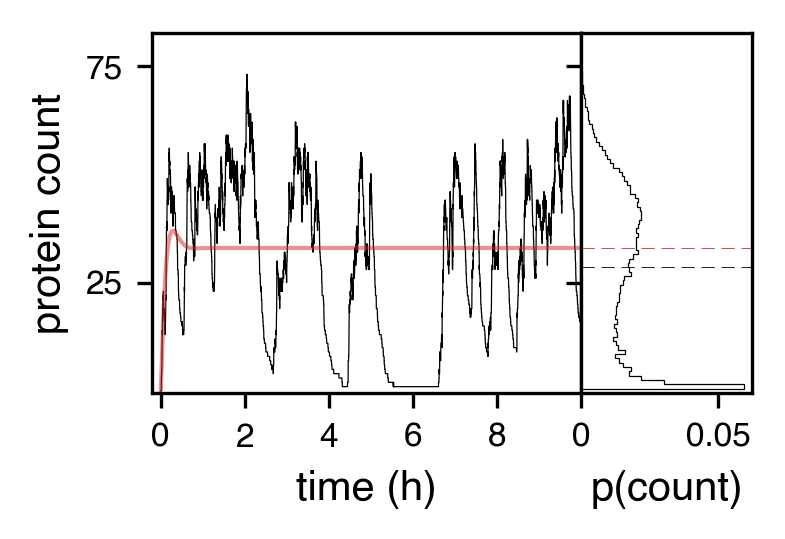

In [215]:
figsize = np.asarray(mpl.rcParams['figure.figsize'])*(.6,1)[::-1]

hdfpth = '../../data/self_regulating_expression_all_%s.hdf'
kinds = ('stochastic', 'deterministic')

names = ('biphasic',)
cols = ('time',) 
oparam_cols = ('p', 'p2', 'p2g_p')
oparam_coeffs = [1, 2, 1]

stoch_data, det_data = [
    getdata(hdfpth, names=names, cols=cols, kind=kind, 
            oparam_cols=oparam_cols, oparam_coeffs=oparam_coeffs)
    for kind in kinds
]

fig,axarr,axlab = plotts(stoch_data, ref_data=det_data, labelmeans=True,
                         truncate=(10*60*60 + 1), yticks=(25,75), figsize=figsize)
axarr[-1,1].xaxis.set_major_formatter(ph.linear_formatter(1))

ph.savefig(fig, 'self_regulating_expression_timeseries_stochastic', '../../figures/');

In [205]:
(32.97 - 28.65)/28.65

0.15078534031413615

In [ ]:
ax.hl

# prepping data

In [151]:
def loadsavehdf(hdfpth, pths, names, dtypes, fixtime=True):
    with h5py.File(hdfpth, mode='w') as f:
        for pth,name,dtype in zip(pths, names, dtypes):
            print(f'saving dataset {name}... ', end='')
            # remove dataset if it exists
            if name in f:
                del f[name]
            
            if isinstance(dtype, (list, tuple)):
                arr = np.loadtxt(pth) if dtype is None else np.loadtxt(pth, dtype=dtype[0])
                arr = arr.astype(dtype=dtype[1])
            else:
                arr = np.loadtxt(pth) if dtype is None else np.loadtxt(pth, dtype=dtype)
                
            print(f'shape {arr.shape}... ', end='')
           
            if fixtime:
                arr['time'] = np.linspace(arr['time'][0], arr['time'][-1], arr['time'].size)
            
            f.create_dataset(name, data=arr, compression='gzip', compression_opts=9)
            print('done')

def doloadsavehdf(names, dtype, kind='stochastic'):
    args = [('../../data/self_regulating_expression_%s_%s.txt' % (name, kind), name, dtype) for name in names]

    loadsavehdf('../../data/self_regulating_expression_all_%s.hdf' % kind, *zip(*args))

In [82]:
dtype = np.dtype([('time', np.float32), ('g_p', np.int32), ('rna_p', np.int32), ('p', np.int32), ('p2', np.int32), ('p2g_p', np.int32)])
names = ('biphasic', 'low_var', 'wilkinson')

doloadsavehdf(names=names, dtype=dtype, kind='stochastic')

saving dataset biphasic...done
saving dataset low_var...done
saving dataset wilkinson...done


In [152]:
dtype = np.dtype([('time', np.float32), ('g_p', np.float32), ('rna_p', np.float32), ('p', np.float32), ('p2', np.float32), ('p2g_p', np.float32)])
names = ('biphasic', 'low_var', 'wilkinson')

doloadsavehdf(names=names, dtype=dtype, kind='deterministic')

saving dataset biphasic... shape (864001,)... done
saving dataset low_var... shape (864001,)... done
saving dataset wilkinson... shape (864001,)... done


In [72]:
dtype = np.dtype([('time', np.float32), ('g_p', np.int32), ('rna_p', np.int32), ('p', np.int32), ('p2', np.int32), ('p2g_p', np.int32)])

# pth = '../../data/self_regulating_expression_test.txt'
# pth = '../../data/self_regulating_expression_low_var_stochastic.txt'
pth = '../../data/self_regulating_expression_biphasic_stochastic.txt'
arr = np.loadtxt(pth, dtype=dtype)

In [73]:
totalp = arr['p'] + arr['p2']*2 + arr['p2g_p']

(array([4.7000e+01, 5.1347e+04, 2.6062e+04, 1.8803e+04, 1.5001e+04,
        1.5768e+04, 1.3183e+04, 1.1957e+04, 1.0844e+04, 1.3811e+04,
        1.1716e+04, 1.0946e+04, 1.0078e+04, 1.1304e+04, 1.1114e+04,
        1.0448e+04, 1.1452e+04, 1.0735e+04, 1.0898e+04, 1.1074e+04,
        1.1479e+04, 1.2009e+04, 1.1969e+04, 1.2346e+04, 1.2447e+04,
        1.3145e+04, 1.3616e+04, 1.5645e+04, 1.5265e+04, 1.4881e+04,
        1.5086e+04, 1.6502e+04, 1.8059e+04, 1.7334e+04, 1.7368e+04,
        1.7403e+04, 1.7992e+04, 1.7243e+04, 1.7829e+04, 1.8246e+04,
        1.8889e+04, 1.9033e+04, 1.8466e+04, 1.7617e+04, 1.8056e+04,
        1.6910e+04, 1.5480e+04, 1.5414e+04, 1.4460e+04, 1.3499e+04,
        1.2799e+04, 1.1972e+04, 1.0150e+04, 9.2090e+03, 8.2380e+03,
        7.6160e+03, 6.7450e+03, 5.6880e+03, 4.7780e+03, 4.1150e+03,
        3.6830e+03, 3.4170e+03, 2.5920e+03, 2.1890e+03, 2.1700e+03,
        1.8180e+03, 1.3560e+03, 1.2290e+03, 9.5000e+02, 6.6200e+02,
        5.8400e+02, 4.2600e+02, 2.2000e+02, 2.79

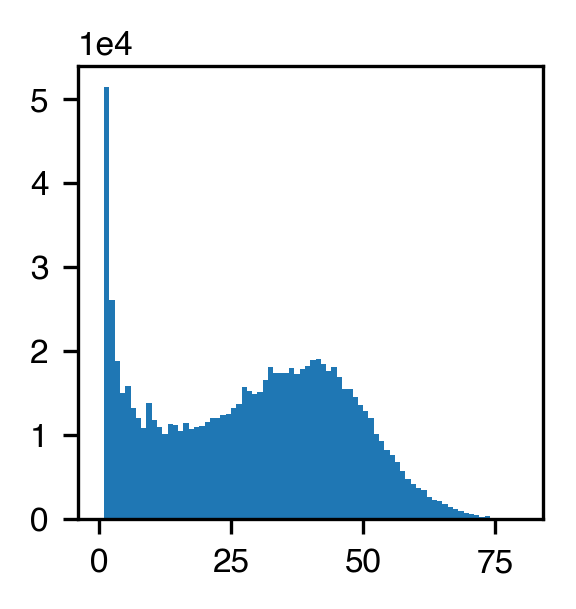

In [78]:
plt.hist(totalp, bins=np.arange(81))#, range=(0,41), bins=41)

In [79]:
totalp.mean()

28.648795545375528

In [18]:
totalp.mean()

24.684933150668492

In [146]:
pths = [f'../../notes_dimerization/{stem}' for stem in (
        'dimerization_deterministic.txt',
        'dimerization_stochastic.txt',
        'dimerization_corrected_deterministic.txt',
        'dimerization_corrected_stochastic.txt')]

dtype = np.dtype([('time', np.float32), ('p', np.float32), ('p2', np.float32)])
for pth in pths:
    arr = np.loadtxt(pth, dtype=dtype)
    print(arr['p'].mean(), arr['p2'].mean())

1.5 2.25
1.0301727 2.4849136
2.0 2.0
1.4645919 2.267704


# 
# 
# 
# 
# old approach

In [ ]:
from pathlib import Path

def loadtxtsavez(pth, name, outpth=None):
    if outpth is None: outpth = pth
        
    arr = np.loadtxt(pth)
    np.savez_compressed(Path(outpth).with_suffix(''), name=arr)
    return arr

loadtxtsavez('../../notes/self_regulating_expression.txt', 'high_var_data', outpth='../../notes/self_regulating_expression_data')

In [6]:
stoch_data = np.load('../../notes/self_regulating_expression_data.npz')

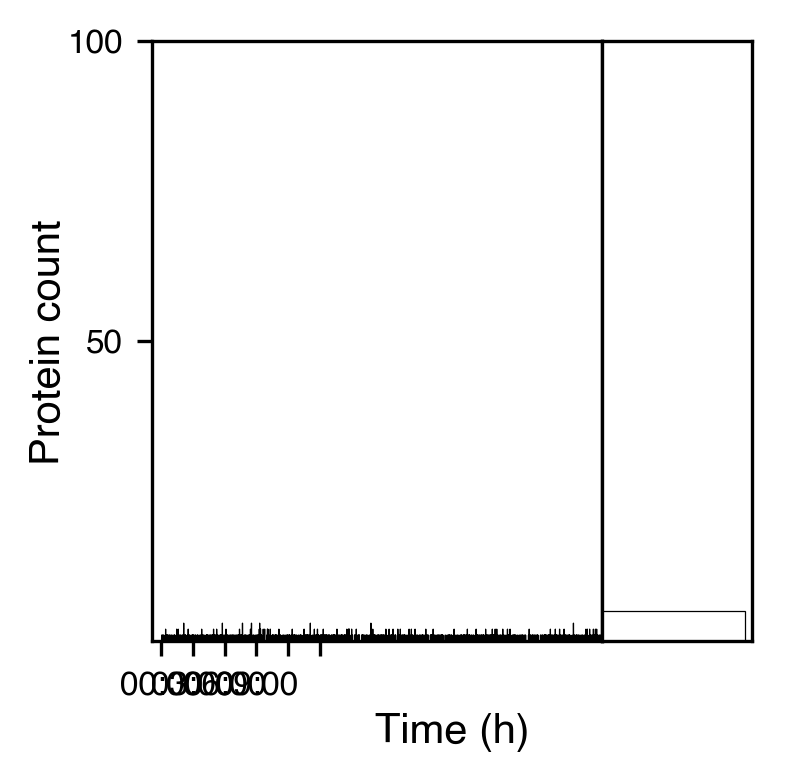

In [10]:
nrows = len(stoch_data)
fig, axarr = plt.subplots(nrows=nrows, ncols=2, sharey=True, squeeze=False,
                          gridspec_kw={'width_ratios': [3,1], 'wspace': 0, 'hspace': 0})
axlab = fig.add_subplot(111, frameon=False)
fig.subplots_adjust(0,0,1,1)
tickkwargs = {m+k:False for k in ('bottom','top','left','right') for m in ('','label')}

hs = []
for data,axrow in zip(stoch_data.values(), axarr):
    time = data[:, 0]
    ax,axhist = axrow
    ax.plot(time, data[:, 2], color="k", lw=.3)
#     ax.plot(t,y[2], color="gray")
    ax.set_yticks([50, 100])
    xrange = time.max() - time.min()
    ax.set_xlim(data[:, 0].min() - xrange*.02, data[:, 0].max())
    ax.set_ylim(0, None)

    h = axhist.hist(data[:, 2], bins=30, range=(0,150), lw=.3, ec="k", fc="none", orientation="horizontal")
    hs.append(h)
    axhist.tick_params(axis="both", **tickkwargs)
    axhist.xaxis.get_offset_text().set_visible(False)

axarr[-1, 0].set_xticks([n*60*60 for n in np.arange(0,11,2)])
axarr[-1, 0].set_xticklabels([str(n).zfill(2) + ':00' for n in np.arange(0, 10, 3)])

axlab.tick_params(axis="both", **tickkwargs)
axlab.set_xlabel('Time (h)', labelpad=17)
axlab.set_ylabel('Protein count', labelpad=20)
ph.savefig(fig, 'simple_expression_timeseries_fixed_mean', '../../figures/');

In [69]:
dists = [h[0]/h[0].sum() for h in hs]

In [70]:
dists

[array([0.00278732, 0.00715098, 0.02868957, 0.05470055, 0.05542686,
        0.07679277, 0.07502373, 0.07906261, 0.08318353, 0.07433135,
        0.06940349, 0.0717295 , 0.07380135, 0.05605695, 0.04786212,
        0.03696533, 0.02849187, 0.0213623 , 0.01823546, 0.0157301 ,
        0.00662266, 0.00451076, 0.00133026, 0.00081056, 0.00077969,
        0.00172734, 0.00120152, 0.00269611, 0.00236077, 0.0011726 ]),
 array([3.07472137e-03, 4.26944326e-04, 5.38888739e-04, 4.14444329e-04,
        2.50833264e-03, 7.64472010e-03, 3.18361023e-02, 9.27460853e-02,
        1.27558576e-01, 1.46948570e-01, 1.95054390e-01, 1.72603841e-01,
        1.34702740e-01, 5.85510948e-02, 1.85386060e-02, 6.78138701e-03,
        7.05555360e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]),
 array([1.48944403e-03, 1.56833290e-03, 1.94

In [31]:
np.linspace(0, 8, 5)

array([0., 2., 4., 6., 8.])

In [19]:
type(stoch_data)

numpy.lib.npyio.NpzFile

In [ ]:
np.histogram(y[])

In [8]:
h

(array([  2.,   2.,   2.,   2.,   2.,   3.,   4.,   6.,  10., 967.]),
 array([7.10542736e-15, 5.00000000e+00, 1.00000000e+01, 1.50000000e+01,
        2.00000000e+01, 2.50000000e+01, 3.00000000e+01, 3.50000000e+01,
        4.00000000e+01, 4.50000000e+01, 5.00000000e+01]),
 <a list of 10 Patch objects>)

In [37]:
stoch_data['high_var_data'][:,2]

array([ 0.,  0.,  0., ..., 51., 51., 51.])

In [20]:
[k for k in stoch_data]

['high_var_data', 'low_var_data', 'min_var_data']